<a href="https://colab.research.google.com/github/songqsh/18ma573v01/blob/master/src/bsm_calibration_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volatility calibration to BSM

## Abstract

- Goal
    - Calibrate BSM model for makert price of options


## Problem

All of pricing models require a set of model parameters in order to fully define the dynamics of each model. The process of adjusting model parameters such that the model prices are compatible with market prices is called **Calibration**. 

Input:

- market prices of several options with different strikes and maturities
- spot price
- interest rates

Output:

- Find volatility of BSM model

## Anal


Suppose
- Model prameter $\theta = (\theta_1, ... \theta_m)$ is a vector
- Prices of $n$ instruments are aviable in the market with its market price of $i$th instrument quoted by $C_i$. 
Let's denote $C = (C_1, ..., C_n)$ as a market price vector.
- In theory, $C_i^\theta$ is the model price of the $i$th instrument, and they are denoted as a vector $C^\theta = (C_1^\theta, ...,  C^\theta_n)$. 

Given a distance function $H: \mathbb R^n \times \mathbb R^n \mapsto \mathbb R^+$, calibration is to find the parameter $\theta^*$  which minimize the objective function $H(C^\theta, C)$, i.e.
$$ \theta^* = \arg\min_\theta H(C^\theta, C).$$

Commonly used distance functions for $H$ are 
- $H(x, y) = (\sum_{i=1}^n w_i |x_i - y_i|^p)^{1/p}.$
- $H(x, y) = (\sum_{i=1}^n w_i | \frac{x_i - y_i}{y_i}|^p)^{1/p}.$ If $p = 2$, $w_i =1$, then $H^2$ is called as SSRE (sum of squred relative errors)
- $H(x, y) = (\sum_{i=1}^n w_i |\ln x - \ln y|^p)^{1/p}.$

In this below, we are goint to use, the first case of $H$ with $p = 2$ and $w_i = 1$ for all i's.

## Code

- git clone repo to colab

In [0]:
'''======
run once, then comment it off, and run again
========'''
!git clone https://github.com/songqsh/18ma573pub.git 
pass

Cloning into '18ma573pub'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 419 (delta 78), reused 1 (delta 0), pack-reused 294
Receiving objects: 100% (419/419), 667.62 KiB | 15.90 MiB/s, done.
Resolving deltas: 100% (233/233), done.


- Change working dir to "reponame/src", also needs run once, and comment it out from the second run.

In [0]:
cd 18ma573pub/src/

/content/18ma573pub/src


- here we import our own python modules and common modules

In [0]:
from european_options_class import VanillaOption
from sde_class import Gbm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so

- Read data from .dat file. It has call option prices of
  - maturities 2 months and 5 months;
  - strikes of 97, 99, 101, 103

In [0]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price
np_option_data1 = np.loadtxt('optiondata2.dat', comments='#', delimiter=',')

print('>>>>>>otype, maturity, strike, option_price')
print(np_option_data1)

>>>>>>otype, maturity, strike, option_price
[[  1.           0.16666667  97.           5.32705461]
 [  1.           0.16666667  99.           3.86224255]
 [  1.           0.16666667 101.           2.7204371 ]
 [  1.           0.16666667 103.           2.1202793 ]
 [  1.           0.41666667  97.           7.23756307]
 [  1.           0.41666667  99.           5.95053461]
 [  1.           0.41666667 101.           5.2640122 ]
 [  1.           0.41666667 103.           4.97493422]]


- We also need to give spot price and interest rate before the computation.

In [0]:
'''==============
below are from the market data for underlying process
================='''
gbm1 = Gbm(
    init_state = 100, #market data
    drift_ratio = .05, #market data
    vol_ratio = .1 #initial guess
)

- creat option_list from the data

In [0]:
num_row = np_option_data1.shape[0]
option_list1 = []

for i in range(num_row):
  option1 = VanillaOption(
      otype = np_option_data1[i,0],
      strike = np_option_data1[i,2],
      maturity = np_option_data1[i,1],
      market_price = np_option_data1[i,3]
  )
      
  option_list1.append(option1) 
  

- Define calibration method

In [0]:
'''==========
define a method for error function
============'''

def error_function(vol, gbm, option_list):
  gbm.vol_ratio = vol
  err1 = 0
  for i in np.arange(len(option_list)):
    err1 = err1 + ((option_list[i]).market_price - gbm.bsm_price(option_list[i]))**2    
  return err1

In [0]:
'''==========
define a method to seek for a calibrated volatility
============'''

def bsm_calibration(gbm, option_list):
  init_vol = .1 #initial guess
  return so.fmin(error_function, init_vol, args = (gbm, option_list), disp = 0)[0]

- filtering out options of 2-mon maturity

In [0]:
# Take options of 2-mon maturity
filter1 = list(filter(lambda x: x.maturity == 2/12, option_list1))
calibrated_volatility1 = bsm_calibration(gbm1, filter1)
print('>>>>>>>> calibrated_volatility is ' + str(calibrated_volatility1))

>>>>>>>> calibrated_volatility is 0.18109375000000028


In [0]:
gbm1.vol_ratio = calibrated_volatility1

#find calibrated option price
filter1_calibrated_price = [gbm1.bsm_price(filter1[i]) for i in range(len(filter1))]
print('>>>>>>>>> this is option price calculated from calibrated vol')
filter1_calibrated_price

>>>>>>>>> this is option price calculated from calibrated vol


[5.184221823763238, 3.9225121216534404, 2.8709333662230563, 2.0297005112870465]

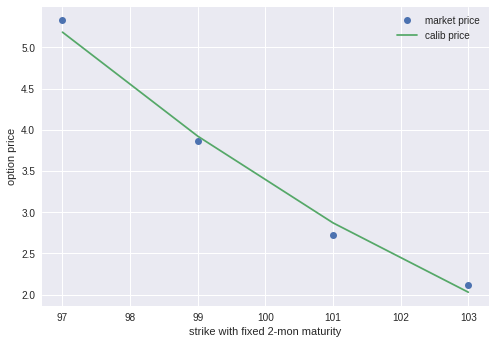

In [0]:
x_co = [filter1[i].strike for i in range(len(filter1))]
y_co = [filter1[i].market_price for i in range(len(filter1))]
plt.plot(x_co, y_co, 'o', label='market price')

y_co = filter1_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed 2-mon maturity')
plt.legend();


- filtering out options of 5-mon maturity

In [0]:
# Take options of 2-mon maturity
filter2 = list(filter(lambda x: x.maturity == 5/12, option_list1))
calibrated_volatility2 = bsm_calibration(gbm1, filter2)
print('>>>>>>>> calibrated_volatility is ' + str(calibrated_volatility2))

>>>>>>>> calibrated_volatility is 0.1839843750000003


In [0]:
gbm1.vol_ratio = calibrated_volatility2

#find calibrated option price
filter2_calibrated_price = [gbm1.bsm_price(filter2[i]) for i in range(len(filter2))]
print('>>>>>>>>> this is option price calculated from calibrated vol')
filter2_calibrated_price

>>>>>>>>> this is option price calculated from calibrated vol


[7.540104147003916, 6.340281448569769, 5.270421573192927, 4.330492653848275]

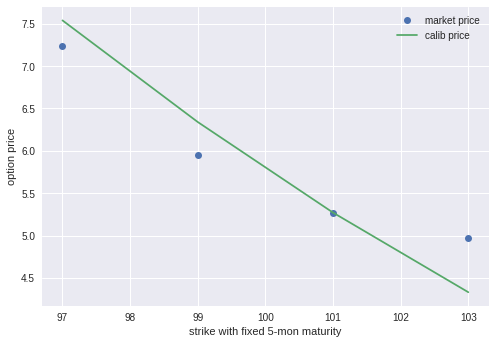

In [0]:
x_co = [filter2[i].strike for i in range(len(filter2))]
y_co = [filter2[i].market_price for i in range(len(filter2))]
plt.plot(x_co, y_co, 'o', label='market price')

y_co = filter2_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed 5-mon maturity')
plt.legend();
